In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))

import math
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader

from embeddings.solver import Solver, cut_weight
from embeddings.main import (
    get_model_dir, 
    embedding_size,
    commit_hash_latest_model
)
from embeddings.datasets import (
    combine,
    all_combined_dataset,
    erdos_renyi_dataset,
    watts_strogatz_dataset,
    barabasi_albert_dataset,
)
from embeddings.feature_generators import (
    degree_ones_features,
    degree_sorted_features,
    degree_rand_features,
    degree_sorted_random_features,
)

from utils import load_pickle

from sklearn.manifold import TSNE

In [2]:
base_dir = "../"
data_dir = os.path.join(base_dir, "data/synthetic")
model_base_dir = os.path.join(base_dir, "embeddings/models")

In [3]:
# choose model and datasets etc.


model_version_hash = commit_hash_latest_model
description = ''#GCN not trained'
k = 2
feature_gen = degree_ones_features

test_data = all_combined_dataset(base_dir=data_dir, indices=range(80, 100), compute_features=feature_gen)
train_data = all_combined_dataset(base_dir=data_dir, indices=range(80), compute_features=feature_gen)
all_data = all_combined_dataset(base_dir=data_dir, indices=range(100), compute_features=feature_gen)

In [4]:
model_dir = get_model_dir(model_base_dir, train_data, k=k, feature_gen=feature_gen,
                          description=description, model_hash=model_version_hash, must_exist=True)

solver = Solver(embedding_size=embedding_size, k=k, model_dir=model_dir, load=True)

In [5]:
embedding_model = solver.embedding_model
global_graph_model = solver.global_graph_model

graph_embeddings = []
node_embeddings = []

data_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4)

for features, adj , n, m, param_info in tqdm(data_loader):
    features, adj = features[0], adj[0]
    embeddings = embedding_model(features, adj)
    
    node_embeddings.append((embeddings, n, m, param_info))
    
    graph_info_input = torch.tensor([n, m, math.log(n), math.log(m), torch.mean(adj), k])

    global_graph_info = global_graph_model(embeddings, graph_info_input)
    
    graph_embeddings.append((global_graph_info, n, m, param_info))

In [6]:
def get_graph_info(graph_dir):
    samples = 10
    n = 0
    m = 0
    cuts = 0
    for i in range(samples):
        f_G = os.path.join(graph_dir, 'G_{}.pkl'.format(i))
        G = load_pickle(f_G)
        n += len(G)
        m += G.number_of_edges()
        
        try:
            f_kern = os.path.join(graph_dir, 'kernighan_lin_{}'.format(i))
            kern_lin = load_pickle(f_kern)
            cuts += cut_weight(G, kern_lin)
        except:
            # kern lin not computed for big graphs
            cuts += float('nan')
            
    n = 1. * n / samples
    m = 1. * m / samples
    density = m / (n * (n-1))
    cuts = 1. * cuts / samples
    return n, m, density, cuts

In [7]:
graph_info = [get_graph_info(x[3][0][0]) for x in tqdm(graph_embeddings)]

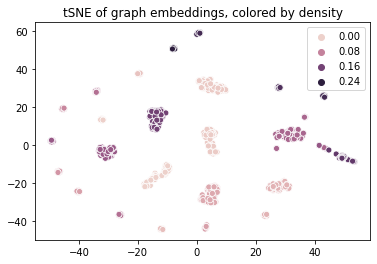

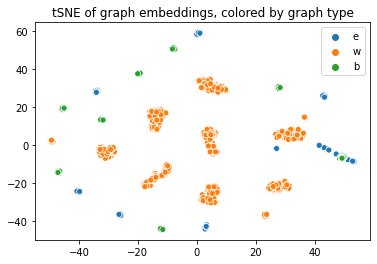

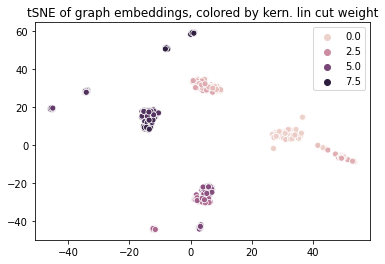

In [14]:
n = None #choose graphs of which size to plot. value in: [None, 10, 100, 500]


X = np.array([graph_embeddings[i][0].detach().numpy()
              for i in range(len(graph_embeddings))
              if n is None or graph_info[i][0] == n])

graph_tsne = TSNE(learning_rate=10, n_iter=2000, perplexity=20).fit_transform(X)

# by density
densities = np.array([x[2] for x in graph_info if n is None or x[0] == n])
sns.scatterplot(graph_tsne[:,0], graph_tsne[:,1], hue=densities)
plt.title("tSNE of graph embeddings, colored by density")
plt.show()

# by type
types = [x[3][1][0][0] for x in graph_embeddings if n is None or x[1] == n]
sns.scatterplot(graph_tsne[:,0], graph_tsne[:,1], hue=types)
plt.title("tSNE of graph embeddings, colored by graph type")
plt.show()

# by cut weight
#no_kern_lin = [500]
weights = np.array([x[3] for x in graph_info if n is None or x[0] == n])
sns.scatterplot(graph_tsne[:,0], graph_tsne[:,1], hue=np.log(weights))
plt.title("tSNE of graph embeddings, colored by kern. lin cut weight")
plt.show()



# Predictions

Only for k = 2 for now

Only investigating graphs of size 100 for now

In [15]:
assert k == 2

In [16]:
data_loader = DataLoader(all_data, batch_size=1, shuffle=False, num_workers=0)

In [17]:
graph_embeddings = []
for features, adj , n, m, param_info in tqdm(data_loader):
    features, adj = features[0], adj[0]
    
    if len(adj) != 100:
        continue
        
    embeddings = embedding_model(features, adj)    
    mean_embedding = torch.mean(embeddings, dim=0).detach().numpy()

    graph_info_input = torch.tensor([n, m, math.log(n), math.log(m), torch.mean(adj), k])

    global_graph_info = global_graph_model(embeddings, graph_info_input)
    
    graph_embeddings.append((global_graph_info, n, m, param_info, graph_info_input, mean_embedding))

In [18]:
graph_info = [get_graph_info(x[3][0][0]) for x in tqdm(graph_embeddings)]

In [19]:
weights = np.array([x[3] for x in graph_info])

In [20]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def regression_report(y_true, y_pred):

    print("RMSE:", math.sqrt(mean_squared_error(y_true, y_pred)))
    print("R-squared", r2_score(y_true, y_pred))
    
    rel = np.mean(np.abs((y_pred / y_true)-1))
    print("Mean relative error: {:.2f}%".format(rel*100))

    plt.scatter(y_true, y_pred, s=1)
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

### predict cut weight kernighan lin

RMSE: 18.55324845840157
R-squared 0.9958233667128077
Mean relative error: 6.29%


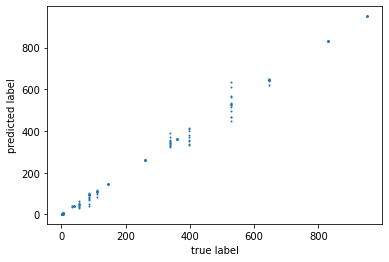

In [21]:
X = np.array([g[0].detach().numpy() for g in graph_embeddings])
y = weights

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=100)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)



y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)

### comparison to only using graph info that is input to global graph attention model

Shows that embeddings are useful

RMSE: 56.87321867182933
R-squared 0.9607534000021383
Mean relative error: 19.21%


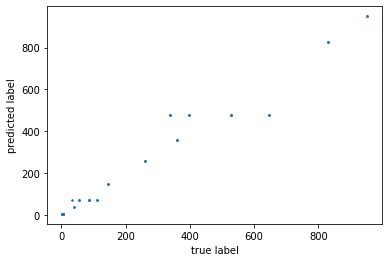

In [22]:
X = np.array([g[4].numpy() for g in graph_embeddings])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=100)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)

y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)

### comparison to using graph info and mean embedding
Shows that Attention useful

RMSE: 30.588072965690003
R-squared 0.9886475222508007
Mean relative error: 8.07%


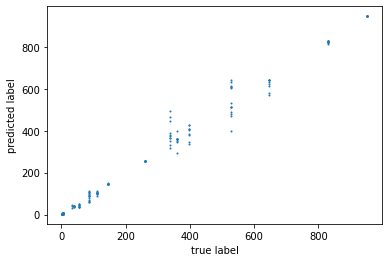

In [23]:
X = np.array([np.concatenate([g[4].numpy(), g[5]], axis=0) for g in graph_embeddings])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=100)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)

y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)

### comparison to using graph info and graph type
Shows that this learns more than from which distribution the graph is

RMSE: 56.87321867182933
R-squared 0.9607534000021383
Mean relative error: 19.21%


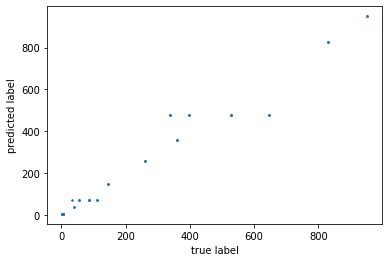

In [25]:
def one_hot(x):
    if x == 'w':
        return np.array([1,0,0])
    elif x == 'b':
        return np.array([0,1,0])
    elif x == 'e':
        return np.array([0,0,1])
    else:
        raise ValueError()

X = np.array([np.concatenate([g[4].numpy(), one_hot(g[3][1][0][0])], axis=0) for g in graph_embeddings])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=100)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)

y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)

### comparison to untrained GCN

right model has to be loaded and important cells executed

In [30]:
# load model with untrained GCN, has to be trained and saved

description = 'GCN not trained'

model_dir = get_model_dir(model_base_dir, train_data, k=k, feature_gen=feature_gen,
                          description=description, model_hash=model_version_hash, must_exist=True)

solver = Solver(embedding_size=embedding_size, k=k, model_dir=model_dir, load=True)

embedding_model = solver.embedding_model
global_graph_model = solver.global_graph_model

In [28]:
data_loader = DataLoader(all_data, batch_size=1, shuffle=False, num_workers=0)

graph_embeddings = []
for features, adj , n, m, param_info in tqdm(data_loader):
    features, adj = features[0], adj[0]
    
    if len(adj) != 100:
        continue
        
    embeddings = embedding_model(features, adj)    
    mean_embedding = torch.mean(embeddings, dim=0).detach().numpy()

    graph_info_input = torch.tensor([n, m, math.log(n), math.log(m), torch.mean(adj), k])

    global_graph_info = global_graph_model(embeddings, graph_info_input)
    
    graph_embeddings.append((global_graph_info, n, m, param_info, graph_info_input, mean_embedding))

weights = np.array([x[3] for x in graph_info])

RMSE: 16.590302951601753
R-squared 0.9966603953456092
Mean relative error: 6.21%


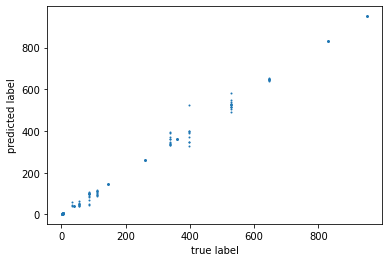

In [29]:
X = np.array([g[0].detach().numpy() for g in graph_embeddings])
y = weights

not_500 = [x[0] != 500 for x in graph_info]
X = X[not_500]
y = y[not_500]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate=0.5, max_depth=10, n_estimators=100)
xg_reg = xg_reg.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="rmse", eval_set=[(X_val, y_val)], verbose=False)



y_true, y_pred = y_test, xg_reg.predict(X_test)

regression_report(y_true, y_pred)